In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
juypter_root = os.readlink('/proc/%s/cwd' % os.environ['JPY_PARENT_PID'])
%cd $juypter_root

/home/bene/Projects/mindcraft


In [3]:
from mindcraft.torch.module import AutoEncoder
from mindcraft.torch.module import Conv
from mindcraft.torch.module import FeedForward
from mindcraft.torch.module import ConvT

In [4]:
def get_MNIST(batch_size, dataset_directory, dataloader_workers, source='MNIST'):
    # Prepare dataset for training
    train_transformation = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
    
    data_source = getattr(torchvision.datasets, source)
    
    train_dataset = data_source(root=dataset_directory, train=True, download=True, transform=train_transformation)

    test_dataset =  data_source(root=dataset_directory, train=False, download=True, transform=train_transformation)

    # Prepare Data Loaders for training and validation
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               pin_memory=True, num_workers=dataloader_workers)

    # Prepare Data Loaders for training and validation
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                              pin_memory=True, num_workers=dataloader_workers)

    return train_dataset, test_dataset, train_loader, test_loader

In [5]:
ENCODER_DROPOUT = 0.3
DECODER_DROPOUT = 0.2
USE_BATCHNORM = True

BATCHSIZE = 32
LEARNINGRATE = 0.005

train_dataset, test_dataset, train_loader, test_loader = get_MNIST(BATCHSIZE, 'examples/dataset', 12, 'MNIST')

In [6]:
def show_latent(data_loader=test_loader):
    y_latent = []
    y_labels = []
    for batch_features, batch_labels in data_loader:
        batch_features = batch_features.to(device)
        y = model.encode(batch_features).detach().cpu().numpy()
        y_latent.extend(y)
        y_labels.extend(batch_labels.numpy())

    y_latent = np.asarray(y_latent)
    y_labels = np.asarray(y_labels)
    
    digit_map = [y_labels == i for i in range(10)]
    
    plt.figure(figsize=(10,10))
    for i, where_i in enumerate(digit_map):
        selection = y_latent[where_i]    
        plt.scatter(*selection[...,:2].T, label=f'#{i}', alpha=0.5)
    plt.legend()
    
    return y_latent

input shape: (1, 28, 28)


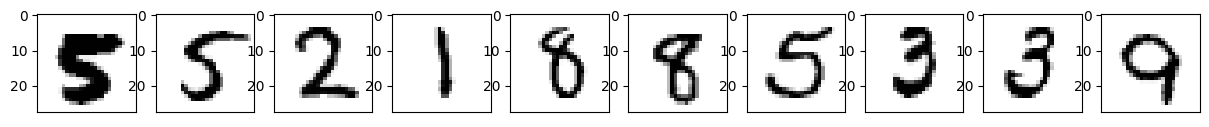

In [7]:
f, axes = plt.subplots(1, 10, figsize=(15, 5))
for ax in axes:
    tensor = train_dataset[np.random.randint(len(train_dataset))][0]
    ax.imshow(tensor.detach().numpy().transpose(1,2,0), cmap='binary')
    ax.set_xticks([]); ax.set_yticks

input_shape = tuple(train_dataset[0][0].shape)
print('input shape:', input_shape)

In [8]:
device = 'cpu'
if torch.cuda.is_available():
    print (f'GPU available')
    device = 'cuda'

x_random = torch.randn(2, *input_shape)
x_random = x_random.to(device)

GPU available


In [9]:
encoder = Conv(
    input_size=1,
    input_dim=2,
    kernel_size=(3, 3, 3, 3, ),
    filters=(32, 64, 64, 64, ),
    strides=(1, 2, 2, 2, ),
    activation=('ReLU','ReLU','ReLU','ReLU', ),
    flatten=True,
    dropout=ENCODER_DROPOUT,
    batch_norm=USE_BATCHNORM
)

encoder = encoder.to(device)
print(encoder.parameters_str)

Conv
cnn.0.weight	(32, 1, 3, 3)
cnn.0.bias	(32,)
cnn.1.weight	(32,)
cnn.1.bias	(32,)
cnn.4.weight	(64, 32, 3, 3)
cnn.4.bias	(64,)
cnn.5.weight	(64,)
cnn.5.bias	(64,)
cnn.8.weight	(64, 64, 3, 3)
cnn.8.bias	(64,)
cnn.9.weight	(64,)
cnn.9.bias	(64,)
cnn.12.weight	(64, 64, 3, 3)
cnn.12.bias	(64,)
cnn.13.weight	(64,)
cnn.13.bias	(64,)
num-params    : 93120
num-trainables: 93120



In [10]:
encoder(x_random).shape

torch.Size([2, 1024])

In [11]:
mu = FeedForward(input_size=1024, output_size=2).to(device)
log_var = FeedForward(input_size=1024, output_size=2).to(device)

In [12]:
mu(encoder(x_random)).shape, log_var(encoder(x_random)).shape

(torch.Size([2, 2]), torch.Size([2, 2]))

In [13]:
decoder = ConvT(
    input_size=2,
    input_dim=2,
    filters=[64, 64, 32, 32],
    kernel_size=[4, 4, 4, 4],
    strides=[1, 3, 3, 2],
    activation=['ReLU', 'ReLU', 'ReLU', 'Sigmoid'],
    dropout=DECODER_DROPOUT,
    batch_norm=USE_BATCHNORM
)

decoder = decoder.to('cuda')
print(decoder.parameters_str)

ConvT
cnn_t.0.weight	(2, 64, 4, 4)
cnn_t.0.bias	(64,)
cnn_t.1.weight	(64,)
cnn_t.1.bias	(64,)
cnn_t.4.weight	(64, 64, 4, 4)
cnn_t.4.bias	(64,)
cnn_t.5.weight	(64,)
cnn_t.5.bias	(64,)
cnn_t.8.weight	(64, 32, 4, 4)
cnn_t.8.bias	(32,)
cnn_t.9.weight	(32,)
cnn_t.9.bias	(32,)
cnn_t.12.weight	(32, 32, 4, 4)
cnn_t.12.bias	(32,)
cnn_t.13.weight	(32,)
cnn_t.13.bias	(32,)
num-params    : 117312
num-trainables: 117312



In [14]:
class ConvMNIST(Conv):
    def forward(x, *args):
        y = Conv.forward(x, *args)
        return y.view(-1, 1, 28, 28)

In [15]:
mu_prime = ConvMNIST(input_size=32, input_dim=2, kernel_size=(3, 3), filters=(16, 1), strides=(1, 1), flatten=False).to(device)
log_var_prime = ConvMNIST(input_size=32, input_dim=2, kernel_size=(3, 3), filters=(16, 1), strides=(1, 1)).to(device)

In [16]:
mu_prime(decoder(mu(encoder(x_random)))).shape

torch.Size([2, 1, 28, 28])

In [17]:
print(mu_prime.parameters_str)

ConvMNIST
cnn.0.weight	(16, 32, 3, 3)
cnn.0.bias	(16,)
cnn.1.weight	(1, 16, 3, 3)
cnn.1.bias	(1,)
num-params    : 4769
num-trainables: 4769



In [18]:
model = AutoEncoder(
    encoder=encoder,
    mu=mu,
    log_var=log_var,
    mu_prime=mu_prime,
    log_var_prime=log_var_prime,
    decoder=decoder,
    beta=5e3,
)

model = model.to(device)
print(model.parameters_str)

AutoEncoder
_log_scale	(1,)
encoder.cnn.0.weight	(32, 1, 3, 3)
encoder.cnn.0.bias	(32,)
encoder.cnn.1.weight	(32,)
encoder.cnn.1.bias	(32,)
encoder.cnn.4.weight	(64, 32, 3, 3)
encoder.cnn.4.bias	(64,)
encoder.cnn.5.weight	(64,)
encoder.cnn.5.bias	(64,)
encoder.cnn.8.weight	(64, 64, 3, 3)
encoder.cnn.8.bias	(64,)
encoder.cnn.9.weight	(64,)
encoder.cnn.9.bias	(64,)
encoder.cnn.12.weight	(64, 64, 3, 3)
encoder.cnn.12.bias	(64,)
encoder.cnn.13.weight	(64,)
encoder.cnn.13.bias	(64,)
mu.nn.0.weight	(2, 1024)
mu.nn.0.bias	(2,)
log_var.nn.0.weight	(2, 1024)
log_var.nn.0.bias	(2,)
mu_prime.cnn.0.weight	(16, 32, 3, 3)
mu_prime.cnn.0.bias	(16,)
mu_prime.cnn.1.weight	(1, 16, 3, 3)
mu_prime.cnn.1.bias	(1,)
log_var_prime.cnn.0.weight	(16, 32, 3, 3)
log_var_prime.cnn.0.bias	(16,)
log_var_prime.cnn.1.weight	(1, 16, 3, 3)
log_var_prime.cnn.1.bias	(1,)
decoder.cnn_t.0.weight	(2, 64, 4, 4)
decoder.cnn_t.0.bias	(64,)
decoder.cnn_t.1.weight	(64,)
decoder.cnn_t.1.bias	(64,)
decoder.cnn_t.4.weight	(64, 64, 4

In [19]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
_log_scale 	 torch.Size([1])
encoder.cnn.0.weight 	 torch.Size([32, 1, 3, 3])
encoder.cnn.0.bias 	 torch.Size([32])
encoder.cnn.1.weight 	 torch.Size([32])
encoder.cnn.1.bias 	 torch.Size([32])
encoder.cnn.1.running_mean 	 torch.Size([32])
encoder.cnn.1.running_var 	 torch.Size([32])
encoder.cnn.1.num_batches_tracked 	 torch.Size([])
encoder.cnn.4.weight 	 torch.Size([64, 32, 3, 3])
encoder.cnn.4.bias 	 torch.Size([64])
encoder.cnn.5.weight 	 torch.Size([64])
encoder.cnn.5.bias 	 torch.Size([64])
encoder.cnn.5.running_mean 	 torch.Size([64])
encoder.cnn.5.running_var 	 torch.Size([64])
encoder.cnn.5.num_batches_tracked 	 torch.Size([])
encoder.cnn.8.weight 	 torch.Size([64, 64, 3, 3])
encoder.cnn.8.bias 	 torch.Size([64])
encoder.cnn.9.weight 	 torch.Size([64])
encoder.cnn.9.bias 	 torch.Size([64])
encoder.cnn.9.running_mean 	 torch.Size([64])
encoder.cnn.9.running_var 	 torch.Size([64])
encoder.cnn.9.num_batches_tracked 	 torch.Size([])
encoder.cnn.12.weight 	 torc

10000 datapoints


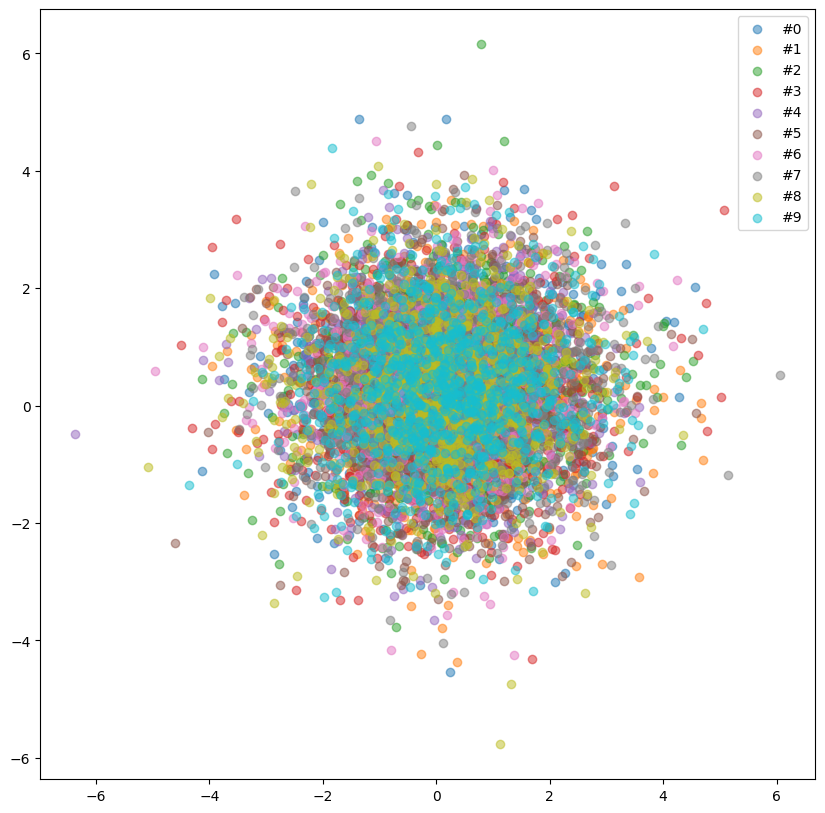

In [20]:
latent_space = show_latent()
print(f'{len(latent_space)} datapoints')

In [21]:
encoding = model.encode(x_random)
y = model(x_random)

print('latent space    :', encoding.shape)
print('output shape    :', y.shape)


latent space    : torch.Size([2, 2])
output shape    : torch.Size([2, 1, 28, 28])


In [22]:
BATCHSIZE = 32
LEARNINGRATE = 0.0005

EPOCHS = 200
WINDOW = 5
STOPPING = 1e-3

N_BATCHSIZE_UPDATES = 5

In [23]:
# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(),  # link to VAE parameters
                             lr=LEARNINGRATE)     # set learning rate

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

In [24]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0005, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': False, 'initial_lr': 0.0005, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]}]


In [25]:
loss_history = []
kl_loss_history = []
r_loss_history = []
valid_history = []
variations = []

In [26]:
def early_stopping(loss_history, rate=1e-4, window=5):
    if len(loss_history) < window:
        return False
    
    if np.absolute(np.std(loss_history[-window:])) < rate:
        print(np.absolute(np.std(loss_history[-window:])))
        return True
    
    return False

batchsize_updates = 0
batchsize_update_rate=1.125

for epoch in range(EPOCHS):
    loss, r_loss, kl_loss = 0, 0, 0

    for batch in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch = [b.to(device) for b in batch]
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # TRAINING STEP: x -> (mu, std) -> (q -> z) -> x_hat
        elbo_loss, kl_loss, r_loss = model.batch_loss(batch, _)

        # compute accumulated gradients
        elbo_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        scheduler.step()

        # add the mini-batch training loss to epoch loss
        loss += elbo_loss.item()
        r_loss += r_loss.item()
        kl_loss += kl_loss.item()
    
    valid = 0
    for test_batch in test_loader:
        test_batch = [b.to(device) for b in test_batch]
        test_loss, *_ = model.batch_loss(test_batch, _)
        valid += test_loss.item()
    
    # compute the epoch training loss
    loss_history.append(loss / len(train_loader))
    r_loss_history.append(r_loss / len(train_loader))
    kl_loss_history.append(kl_loss / len(train_loader))                        
    valid_history.append(valid / len(test_loader))
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f} (KL: {:.6f}, RECON.: {:.6f}), valid = {:.6f}".format(epoch + 1, 
                                                                                             EPOCHS, 
                                                                                             loss_history[-1], 
                                                                                             kl_loss_history[-1],
                                                                                             r_loss_history[-1],
                                                                                             valid_history[-1],
                                                                                            ))
    
    if early_stopping(loss_history, rate=STOPPING, window=WINDOW):
        break
    
    if epoch > 0 and epoch % 10 == 0:
        if batchsize_updates < N_BATCHSIZE_UPDATES:
            batchsize_updates += 1
            BATCHSIZE = int(batchsize_update_rate * BATCHSIZE)
            train_dataset, test_dataset, train_loader, test_loader = get_MNIST(
                BATCHSIZE, 'examples/dataset/', 12, 'MNIST')
            print(f"update batchsize to {BATCHSIZE}")
            
        else:
            print(f"early stopping: could not improve validation of model in range {STOPPING} in {WINDOW} consecutive epochs")
            break
        
        

epoch : 1/200, loss = 2862560.625867 (KL: 0.027646, RECON.: 2195.393799), valid = 2075132.001997
epoch : 2/200, loss = 1303975.874100 (KL: 0.029846, RECON.: 666.648499), valid = 622970.605331
epoch : 3/200, loss = 176627.703467 (KL: 0.034445, RECON.: -199.494843), valid = -178115.800220
epoch : 4/200, loss = -333424.667668 (KL: 0.035428, RECON.: -671.081238), valid = -391953.622902
epoch : 5/200, loss = -415962.749699 (KL: 0.027186, RECON.: -441.023315), valid = -426013.604193
epoch : 6/200, loss = -434755.246849 (KL: 0.034183, RECON.: -484.959686), valid = -427512.638294
epoch : 7/200, loss = -452201.134843 (KL: 0.033541, RECON.: -444.480347), valid = -441463.408035
epoch : 8/200, loss = -463245.753475 (KL: 0.026118, RECON.: -580.100830), valid = -465112.677737
epoch : 9/200, loss = -473438.107558 (KL: 0.026001, RECON.: -715.669067), valid = -459285.207313
epoch : 10/200, loss = -482923.854159 (KL: 0.030609, RECON.: -458.335663), valid = -477567.918665
epoch : 11/200, loss = -489214.9

ValueError: Expected parameter scale (Tensor of shape (45, 1, 28, 28)) of distribution Normal(loc: torch.Size([45, 1, 28, 28]), scale: torch.Size([45, 1, 28, 28])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[[[4.1015e-09, 1.0356e-13, 7.4505e-14,  ..., 9.7586e-13,
           8.1718e-12, 3.0077e-08],
          [9.3138e-14, 2.5273e-20, 6.0550e-20,  ..., 8.0214e-20,
           2.0341e-18, 1.5592e-12],
          [6.6347e-15, 9.1291e-22, 5.4694e-21,  ..., 5.6168e-23,
           1.5428e-21, 1.3201e-14],
          ...,
          [5.1027e-12, 3.8571e-19, 3.4448e-22,  ..., 5.3867e-23,
           8.3089e-23, 5.4461e-16],
          [2.0601e-11, 4.6475e-18, 5.8838e-21,  ..., 1.8928e-22,
           1.9350e-21, 9.7454e-15],
          [8.1436e-08, 6.1486e-12, 1.0854e-13,  ..., 4.4000e-15,
           4.8582e-14, 2.2299e-09]]],


        [[[3.9094e-08, 7.8194e-13, 5.8296e-14,  ..., 2.9157e-14,
           5.7990e-13, 9.6463e-09],
          [2.4272e-12, 6.4933e-19, 4.5100e-20,  ..., 4.2614e-20,
           2.8574e-18, 4.7346e-12],
          [4.8372e-13, 2.2791e-19, 6.5108e-20,  ..., 7.0300e-20,
           3.1559e-18, 4.0903e-12],
          ...,
          [1.9227e-11, 4.7669e-18, 3.9217e-20,  ..., 6.2432e-19,
           4.8736e-18, 1.9797e-12],
          [1.3578e-11, 4.6329e-18, 6.8567e-20,  ..., 4.2597e-20,
           1.4122e-18, 2.1554e-12],
          [3.0184e-08, 2.3566e-12, 2.2277e-13,  ..., 5.7370e-14,
           1.2297e-12, 2.8993e-08]]],


        [[[7.1896e-08, 2.1700e-12, 6.0460e-14,  ..., 3.1287e-15,
           5.7221e-14, 1.9534e-09],
          [8.5830e-12, 3.7917e-18, 5.4324e-20,  ..., 3.2256e-22,
           1.7213e-20, 1.3756e-13],
          [2.0393e-12, 1.2384e-18, 3.4812e-20,  ..., 6.0668e-23,
           1.3991e-21, 2.1676e-14],
          ...,
          [2.3553e-13, 7.2408e-21, 3.7358e-23,  ..., 7.7459e-20,
           7.2288e-20, 6.5589e-14],
          [3.3442e-13, 1.7032e-20, 1.6487e-22,  ..., 1.0458e-19,
           5.8581e-19, 8.6495e-13],
          [2.7799e-09, 6.8539e-14, 4.9576e-15,  ..., 2.1478e-13,
           1.9402e-12, 3.6339e-08]]],


        ...,


        [[[1.4948e-07, 1.1892e-11, 4.2995e-13,  ..., 7.9249e-15,
           2.7370e-13, 6.2291e-09],
          [1.7907e-11, 1.6824e-17, 2.5061e-19,  ..., 1.0451e-21,
           2.7184e-19, 1.4208e-12],
          [9.4732e-13, 2.8169e-19, 1.0343e-20,  ..., 2.7264e-22,
           5.6371e-20, 4.7383e-13],
          ...,
          [4.7143e-15, 2.0389e-23, 3.4811e-25,  ..., 1.8509e-20,
           6.8691e-19, 1.0833e-12],
          [4.0217e-14, 3.5785e-21, 6.2831e-22,  ..., 8.4549e-21,
           4.3944e-19, 1.4533e-12],
          [1.6927e-09, 1.2344e-13, 9.1163e-14,  ..., 3.5886e-14,
           6.3555e-13, 2.1929e-08]]],


        [[[7.9885e-09, 5.7897e-14, 3.0427e-15,  ..., 1.7168e-15,
           6.0377e-14, 1.5824e-09],
          [9.3424e-14, 2.4786e-21, 8.4867e-23,  ..., 6.4369e-23,
           1.2436e-20, 9.2095e-14],
          [3.9682e-15, 3.9246e-23, 3.3773e-24,  ..., 4.5609e-24,
           5.9334e-22, 1.1607e-14],
          ...,
          [8.7593e-16, 3.4103e-24, 2.6102e-25,  ..., 1.8930e-28,
           1.1941e-26, 8.2963e-18],
          [1.9946e-15, 1.3373e-23, 6.9799e-25,  ..., 3.6358e-26,
           4.4087e-24, 7.1526e-16],
          [1.1344e-10, 6.8005e-16, 7.9002e-17,  ..., 5.8977e-17,
           2.5722e-15, 6.7733e-10]]],


        [[[5.4500e-08, 2.8919e-12, 4.0043e-13,  ..., 2.5521e-14,
           2.6195e-13, 7.1488e-09],
          [5.9158e-12, 5.7355e-18, 9.3358e-19,  ..., 3.3614e-21,
           1.9704e-19, 1.1625e-12],
          [8.6684e-13, 8.2561e-19, 4.7876e-19,  ..., 2.2192e-22,
           3.1328e-20, 3.4364e-13],
          ...,
          [3.1261e-16, 1.5746e-24, 1.3468e-25,  ..., 1.4314e-22,
           6.0404e-22, 4.5886e-15],
          [8.7235e-15, 4.6159e-22, 5.8556e-23,  ..., 1.8234e-20,
           4.9092e-20, 1.0939e-13],
          [9.8815e-10, 4.0806e-14, 1.3178e-14,  ..., 2.6472e-13,
           6.4134e-13, 1.0622e-08]]]], device='cuda:0', grad_fn=<ExpBackward0>)

In [27]:
from mindcraft.torch.util import tensor_to_numpy

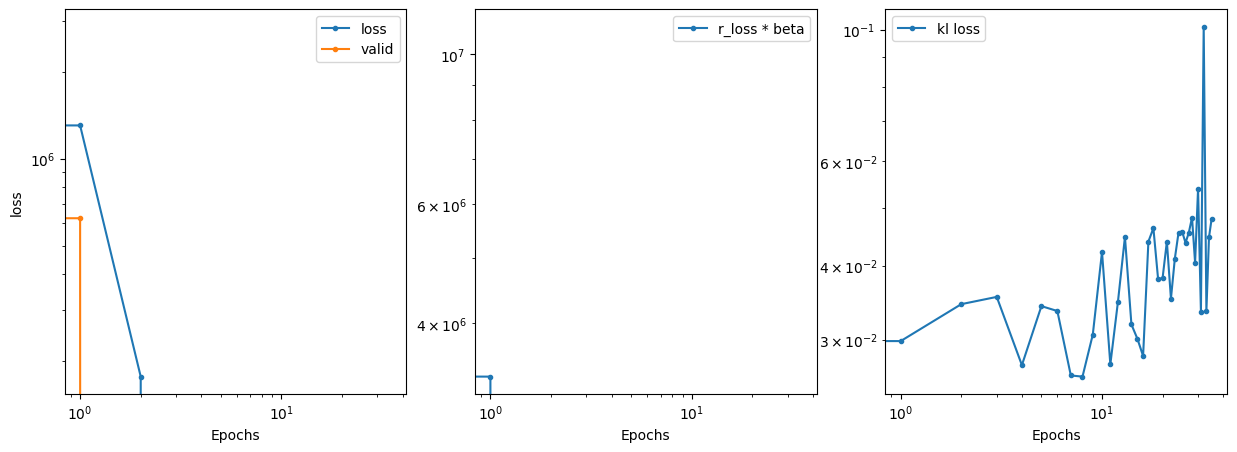

In [28]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

ax1.loglog(loss_history, marker='.', label='loss')
ax1.loglog(valid_history, marker='.', label='valid')
ax2.loglog(np.asarray([tensor_to_numpy(r) for r in r_loss_history]) * model.beta, marker='.', label='r_loss * beta')
ax3.loglog([tensor_to_numpy(r) for r in kl_loss_history], marker='.', label='kl loss')
ax1.set_ylabel('loss')
[axi.set_xlabel('Epochs') for axi in [ax1, ax2, ax3]]
[axi.legend() for axi in [ax1, ax2, ax3]];

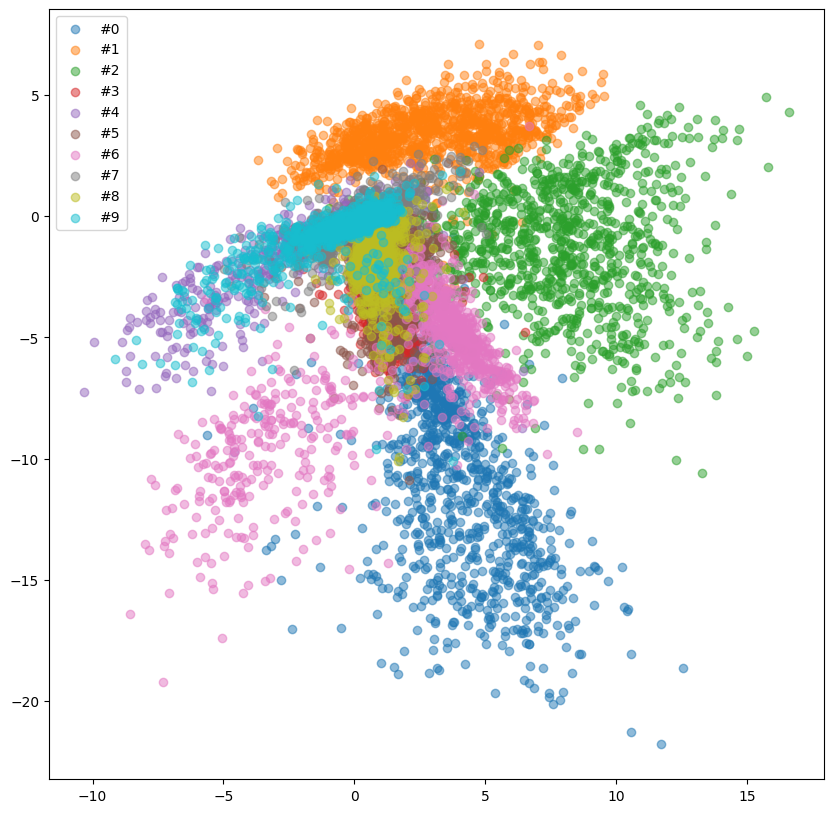

In [29]:
y_latent = show_latent()

In [30]:
y_latent_range = list({'min': li.min(), 'mean': li.mean(), 'max': li.max()} for li in y_latent.T)
y_latent_range

[{'min': -10.3185215, 'mean': 1.8723028, 'max': 16.60232},
 {'min': -21.789185, 'mean': -2.3859048, 'max': 7.089071}]

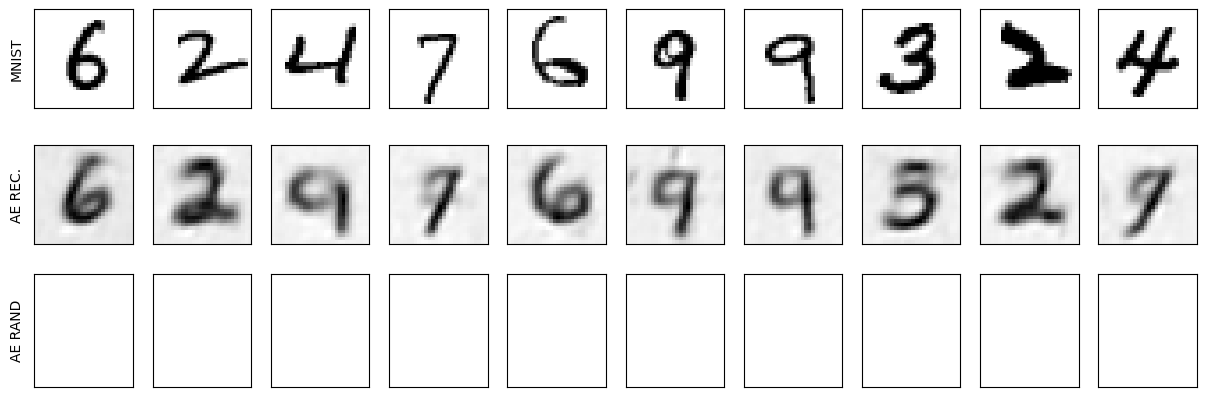

In [32]:
n = 10

z_rand = np.random.rand(n, 2)
for i in range(z_rand.shape[-1]):
    range_i = (y_latent_range[i]['max'] - y_latent_range[i]['min'])
    offset_i = 0.5 - y_latent_range[i]['mean'] / range_i
    z_rand[..., i] -= offset_i
    z_rand[..., i] *= range_i
    
t_rand = torch.from_numpy(z_rand).float().to(device)
y_rand = model.decoder(t_rand)
y_numpy = y_rand.detach().cpu().numpy()

f, axes = plt.subplots(3, n, figsize=(15, 5))
tensor_choice = [np.random.randint(len(train_dataset)) for __ in range(n)]

my_subset = torch.utils.data.Subset(train_dataset, tensor_choice)
loader = torch.utils.data.DataLoader(my_subset, batch_size=len(tensor_choice))
for tensors, __ in loader:
    reconst = model(tensors.to(device))

    for i, ax in enumerate(axes.T):
        ax[0].imshow(tensors[i].detach().numpy().transpose(1,2,0), cmap='binary')
        ax[1].imshow(reconst[i].detach().cpu().numpy().transpose(1,2,0), cmap='binary')

        # ax[2].imshow(y_numpy[i].transpose(1,2,0), cmap='Blues')
        ax[0].set_xticks([]); ax[0].set_yticks([])
        ax[1].set_xticks([]); ax[1].set_yticks([])
        ax[2].set_xticks([]); ax[2].set_yticks([])

    axes[0][0].set_ylabel('MNIST');
    axes[1][0].set_ylabel('AE REC.');
    axes[2][0].set_ylabel('AE RAND');

In [33]:
offset = 15
encodings = []

for i, (batch_features, __) in enumerate(test_loader):
    latent = model.encode(batch_features.to(device))
    encodings.append(tensor_to_numpy(latent))
        
encodings = np.concatenate(encodings, axis=0)

## Latent Space Distros

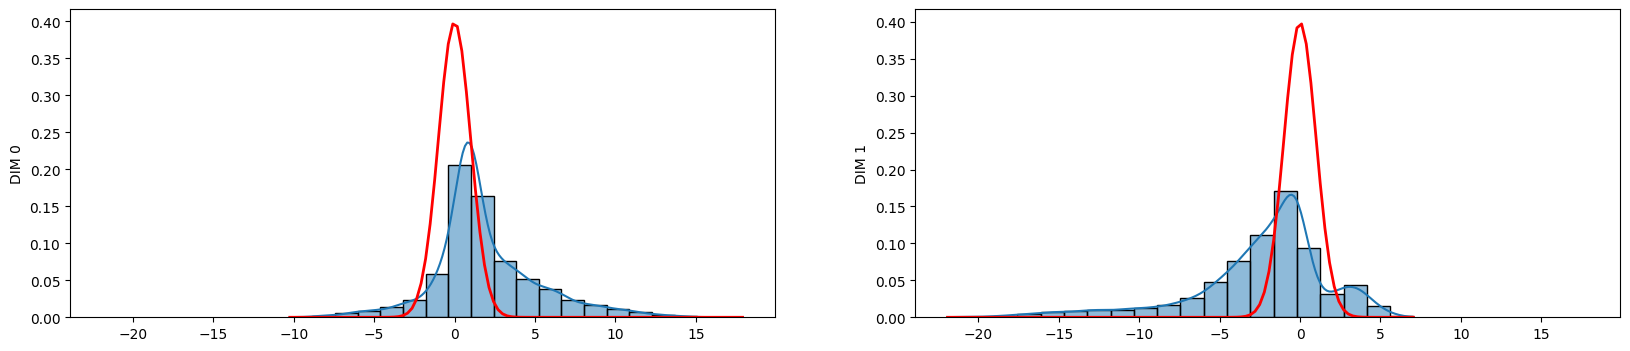

In [34]:
h_split = 2
f, axes = plt.subplots(int(2//h_split), h_split, figsize=(20, 4), sharex=True)

dim = 0
for cols in axes:
    for ax in cols if hasattr(cols, '__iter__') else [cols]:
               
        # show data distribution
        sns.histplot(encodings[:, dim], bins=20, ax=ax, kde=True, stat='density')
        
        # calculate the pdf over a range of values
        xx = np.linspace(min(encodings[:, dim]), max(encodings[:, dim]), 101)
        yy = stats.norm.pdf(xx)                                                         
        
        # and plot on the same axes that seaborn put the histogram
        ax.plot(xx, yy, 'r', lw=2)   
        ax.set_ylabel(f"DIM {dim}")
        
        dim += 1

In [35]:
class LatentExplorer():
    def __init__(self, z_size, model, z_dim=0, x0=None):
        self.z_dim = z_dim
        self.z_size = z_size
        self.z_value = self.randomize()
        self._randomize = False
        self.model = model
    
    def randomize(self):
        return np.random.randn(self.z_size)

    def explore(self):                      
        @interact
        def decode(z_dim=['0', '1'], value=(-3., 3., 0.1), randomize=self._randomize, true_colors=False):
            hue = ['tab:blue'] * self.z_size
            fig = plt.figure(figsize=(15, 3))
            ax1 = plt.subplot2grid((1,4), (0, 0))
            ax2 = plt.subplot2grid((1,4), (0, 1), colspan=3)
                        
            try:
                if randomize != self._randomize:
                    self.z_value = self.randomize()
                    self._randomize = randomize
                    
                i = int(z_dim)
                self.z_value[i] = value
                hue[i] = 'tab:orange'
                
                x_hat = self.model.decode(torch.Tensor(self.z_value[None,...]).to(device))
                x_hat = tensor_to_numpy(x_hat)[0].transpose((1,2,0))
                if true_colors:
                    x_hat = 1 - x_hat

                plt.figure(figsize=(3, 3))
                ax1.imshow(x_hat)        
                
            except:
                raise
                
            
            x = np.arange(0, self.z_size, 1)
            y = self.z_value
            
            ax2.bar(x, y, color=hue)
            ax2.set_ylim([-3, 3])
            ax2.grid()
            print('z:', self.z_value)
            plt.show()
    

# LatentExplorer(z_size=2, model=model).explore()

In [36]:
LatentExplorer(2, model).explore()

interactive(children=(Dropdown(description='z_dim', options=('0', '1'), value='0'), FloatSlider(value=0.0, des…